

Oblig2 ML Dat158 Playing the whole game (Niklas Johansson, Darren Bernardo, Per-Helge Litzheim, Hassan Ali Abdullahi)

During this exercise we will follow the eight steps of Appendix B:

 1   Frame the problem and look at the big picture
 2   Get the data
 3   Explore the data to gain insights
 4   Prepare the data
 5   Explore many different models and short-list the best ones
 6   Fine-tune your models and combine them into a great solution
 7   Present your solution
 8   Launch, monitor and maintain your system
    

**1. Framing the problem**


**2. Getting the Data**

In [4]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # prettier plotting
import lightgbm as lgb
import itertools
import ast
import eli5
import time
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from scipy import stats
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
#test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
#sample_submission = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')

train = pd.read_csv('DATA/train.csv')
test = pd.read_csv('DATA/test.csv')
sample_submission = pd.read_csv('DATA/sample_submission.csv')

X = train
X.revenue = np.log1p(train.revenue) # Metric to use: Root-Mean-Squared-Logarithmic-Error (RMSLE) between the predicted value and the actual revenue. Logs are taken to not overweight blockbuster revenue movies.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [6]:
# checking shape of data
shape = train.shape
train.shape, test.shape



((3000, 23), (4398, 22))


**3. Exploring the data**

The set has allready been split into a train and a test set. In this case we have 3000 entries in the test set and 4398 in the test set. This is far away from the normal 80/20 split and seems unfortunate when the test set is so small. With 21 columns of data there is a lot to play with so lets see what it contains:


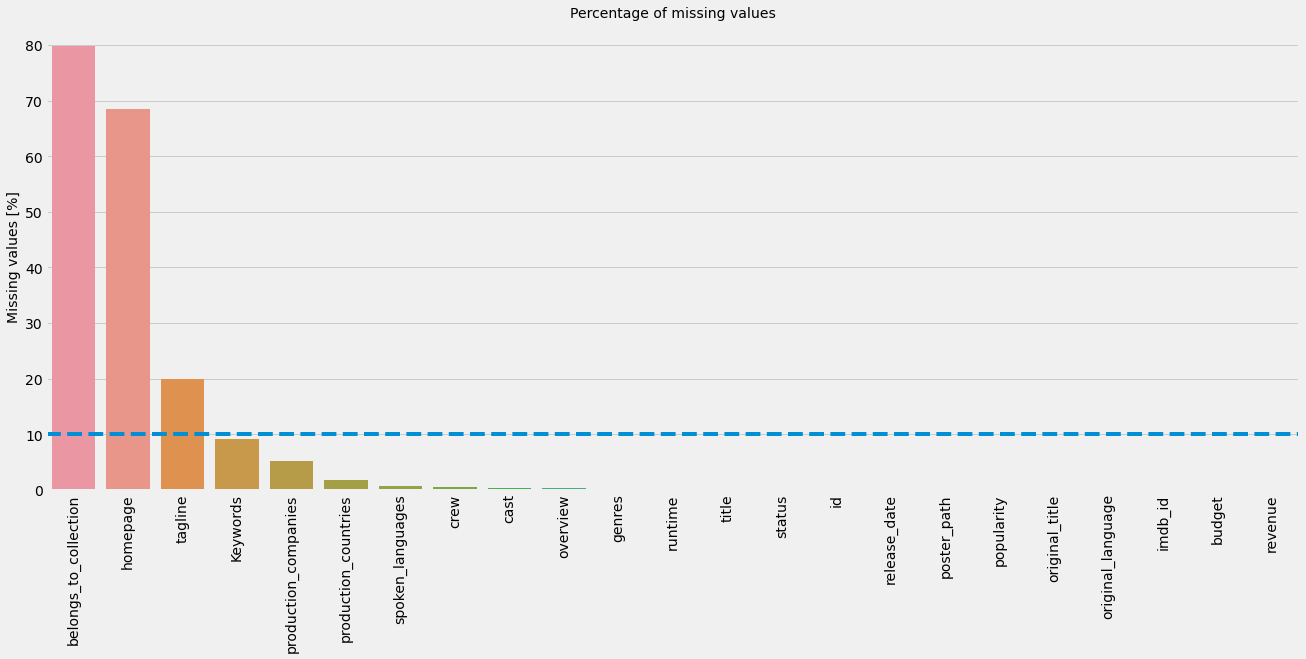

In [7]:
# calculate percentage of missing values
pct_nans = round(train.isnull().sum()/shape[0]*100,1).to_frame().sort_values(by=[0], ascending=False)
# create a bar chart
plt.figure(figsize=(20,8))
sns.barplot(x=pct_nans.index, y=pct_nans[0])
plt.axhline(10, ls="--")
plt.xticks(rotation=90, fontsize=14)
plt.title("Percentage of missing values", fontsize=14)
plt.ylabel("Missing values [%]", fontsize=14)
plt.show()

In [8]:
train

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.326300
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",18.370959
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",16.387512
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16.588099
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",15.182615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",14.283442
2996,2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,3/28/13,102.0,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,NaN,We Are the Best!,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",12.103990
2997,2998,NaN,65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,10/11/96,120.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What's forgotten is not always gone.,The Long Kiss Goodnight,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de...",18.309266
2998,2999,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...

**Belongs_to_collection:**  
Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. Lets keep it simple and make it a yes(1)/no(0).



In [9]:
train.belongs_to_collection.describe()

count                                                   604
unique                                                  422
top       [{'id': 645, 'name': 'James Bond Collection', ...
freq                                                     16
Name: belongs_to_collection, dtype: object

**Budget:** 
Budget of a movie in dollars. 0 values mean unknown. A lot of unknown values, we should try to replace theese(values can be stolen from other Notebooks)

**Homepage:** 
Contains the official homepage URL of a movie.    

**Imdb_id, Keywords, Poster path, Original_title, Overview,Spoken languages, Status & Title:**
Theese contains mostly useless links or are of little consequence, I'll drop'em for now!

In [10]:
# Status: Only 4 values in "Rumored"! Remove Status..
train.status.value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [11]:
train.Keywords.value_counts()

[{'id': 10183, 'name': 'independent film'}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              27
[{'id': 187056, 'name': 'woman director'}]                                                                                                                                                                                                                                                                                                                                                                                                                  

**Original_language:**
Two digit code of the original language, in which the movie was made. Like: en = English, fr = french. (Finished)

**Popularity:** Popularity of the movie in float

**Production_companies:** All production company name and TMDB id in JSON format of a movie.

**Production_countries:** Two digit code and full name of the production company in JSON format.

In [12]:
train.production_countries.value_counts()

[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                                                            1752
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                             118
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                                                                        94
[{'iso_3166_1': 'IN', 'name': 'India'}]                                                                                                                                                 69
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                                                                                                51
                                                                 

**Release_date:** Release date of a movie in mm/dd/yy format.

In [13]:
test.release_date.head(20)

0      7/14/07
1      5/19/58
2      5/23/97
3       9/4/10
4      2/11/05
5       2/7/96
6     12/23/10
7      2/11/00
8       3/2/07
9     10/30/99
10      9/1/05
11     6/27/14
12     9/10/80
13     5/16/02
14      9/9/08
15     9/12/10
16     3/26/10
17     4/16/14
18    12/20/79
19    11/18/97
Name: release_date, dtype: object

**Runtime:** Total runtime of a movie in minutes (Integer).

**Tagline**: Tagline of a movie 

**Cast:** All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

In [14]:
train.cast.describe()
#train.cast.head()

count     2987
unique    2975
top         []
freq        13
Name: cast, dtype: object

**Crew:** Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc. (Use Director)

In [15]:
train.crew.value_counts()

[{'credit_id': '52fe426ac3a36847f801ce4d', 'department': 'Directing', 'gender': 2, 'id': 24, 'job': 'Director', 'name': 'Robert Zemeckis', 'profile_path': '/isCuZ9PWIOyXzdf3ihodXzjIumL.jpg'}, {'credit_id': '52fe426ac3a36847f801ce53', 'department': 'Writing', 'gender': 2, 'id': 10293, 'job': 'Novel', 'name': 'Carl Sagan', 'profile_path': '/rFUPXJSBi6ybau4x56vLrTjvitb.jpg'}, {'credit_id': '52fe426ac3a36847f801ce59', 'department': 'Writing', 'gender': 2, 'id': 10295, 'job': 'Screenplay', 'name': 'James V. Hart', 'profile_path': '/uwRqqSLT3qY2tYJET0uDFUbyiHK.jpg'}, {'credit_id': '52fe426ac3a36847f801ce5f', 'department': 'Writing', 'gender': 2, 'id': 10296, 'job': 'Screenplay', 'name': 'Michael Goldenberg', 'profile_path': '/qU4WTFJN8z7w3VYYDbl9EH3ifNn.jpg'}, {'credit_id': '52fe426ac3a36847f801ce85', 'department': 'Sound', 'gender': 2, 'id': 37, 'job': 'Original Music Composer', 'name': 'Alan Silvestri', 'profile_path': '/chEsfnDEtRmv1bfOaNAoVEzhCc6.jpg'}, {'credit_id': '52fe426ac3a36847f80

**Revenue:** Total revenue earned by a movie in dollars. (Label)

In [16]:
# checking how the train data correlates to label(revenue)

corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue       1.000000
budget        0.485856
popularity    0.288506
runtime       0.210098
id            0.014447
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Budget')

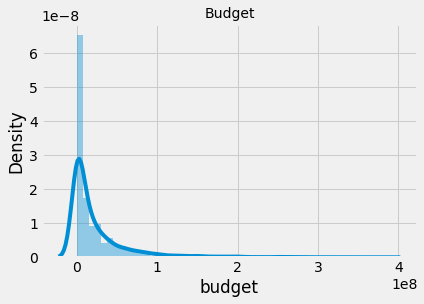

In [17]:
sns.distplot(train["budget"])
plt.title( "Budget", fontsize=14)

Text(0.5, 1.0, 'Revenue')

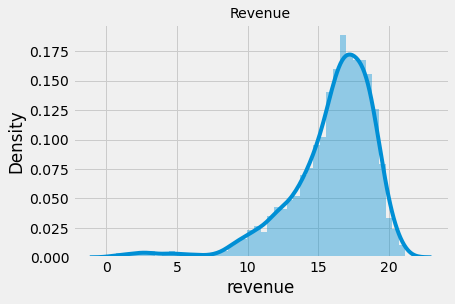

In [18]:
sns.distplot(train["revenue"])
plt.title( "Revenue", fontsize=14)



**4. Preparing the data**

Time to fix the things that needed fixing, a lot of cleaning needed:


**release_date**

In [19]:
# Splitting release_date into multiple columns
def date_features(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df.drop(columns=['release_date'], inplace=True)
    return df

train = date_features(train)

#What have we done!?
train[["release_year", "release_month"]].describe()

,release_year,release_month
count,3000.000000,3000.000000
mean,2004.779667,6.775333
std,15.664767,3.409115
min,1970.000000,1.000000
25%,1995.000000,4.000000
50%,2006.000000,7.000000
75%,2012.000000,10.000000
max,2069.000000,12.000000


I'm slightly worried about release_year = 2069 (hopefully its back to the future) lets check this:

In [20]:
train[train["release_year"] >=2017]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,release_year,release_month
39,40,NaN,3800000,"[{'id': 10752, 'name': 'War'}, {'id': 37, 'nam...",NaN,tt0059418,en,Major Dundee,"During the last winter of the Civil War, caval...",3.055936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Major Dundee,"[{'id': 534, 'name': 'mexico'}, {'id': 1968, '...","[{'cast_id': 1, 'character': 'Major Amos Charl...","[{'credit_id': '52fe45f5c3a368484e078d7b', 'de...",9.607370,2065,4
41,42,NaN,3000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,tt0061512,en,Cool Hand Luke,When petty criminal Luke Jackson is sentenced ...,9.718713,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What we've got here is failure to communicate.,Cool Hand Luke,"[{'id': 378, 'name': 'prison'}, {'id': 526, 'n...","[{'cast_id': 13, 'character': 'Luke Jackson', ...","[{'credit_id': '52fe428ac3a36847f8026d8d', 'de...",16.601618,2067,6
48,49,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,tt1781058,en,Wilson,"Middle-aged and divorced, Wilson finds himself...",8.984386,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Wilson,"[{'id': 2487, 'name': 'naivety'}, {'id': 2794,...","[{'cast_id': 5, 'character': 'Wilson', 'credit...","[{'credit_id': '5590cb95c3a36807f6000075', 'de...",13.390789,2017,3
51,52,NaN,12000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,tt0059243,en,The Great Race,"Professional daredevil and white-suited hero, ...",4.473327,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"The movie with 20,000-mile or one-million-laug...",The Great Race,"[{'id': 9253, 'name': 'slapstick'}, {'id': 159...","[{'cast_id': 1, 'character': 'Prof. Fate', 'cr...","[{'credit_id': '52fe445e9251416c75032581', 'de...",17.047632,2065,7
61,62,NaN,4000000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0049875,en,Trapeze,"A pair of men try to perform the dangerous ""tr...",1.801071,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,High...High...High...Above Them All! - in exci...,Trapeze,"[{'id': 291, 'name': 'circus'}, {'id': 180181,...","[{'cast_id': 2, 'character': 'Mike Ribble', 'c...","[{'credit_id': '52fe4594c3a36847f80cf3b9', 'de...",16.482739,2056,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,2946,NaN,1000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,tt0057590,en,Tom Jones,Tom loves Sophie and Sophie loves Tom. But Tom...,3.315827,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Tom Jones! . . . loves and loves and loves and...,Tom Jones,"[{'id': 5626, 'name': 'from rags to riches'}, ...","[{'cast_id': 6, 'character': 'Tom Jones', 'cre...","[{'credit_id': '52fe4421c3a36847f8084025', 'de...",17.442515,2063,10
2946,2947,NaN,483103,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,tt0018183,en,My Best Girl,"Joe Merrill, son of the millionaire owner of a...",0.205671,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,My Best Girl,NaN,"[{'cast_id': 1, 'character': 'Maggie Johnson',...","[{'credit_id': '58f2c8ac9251413d6e007220', 'de...",13.842890,2027,10
2962,2963,NaN,20000000,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://www.theshack.movie,tt2872518,en,The Shack,"After suffering a family tragedy, Mack Phillip...",16.392712,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,You're never as alone as you think.,The Shack,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 0, 'character': 'Mack Phillips', ...","[{'credit_id': '591ed967c3a368799b03016c', 'de...",17.864350,2017,3
2967,2968,"[{'id': 387219, 'name': 'The Hustler Collectio...",2000000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0054997,en,The Hustler,Fast Eddie Felson is a small-time pool hustler...,9.333533,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They called him Fast Eddie. 

Ok so we can note two things. The "newest" movies are from 2017. And the movies from the future is actually from the past i.e. The Hustler('2061') is actually from 1961.

Let's check if the same is true for the test set:

In [21]:
#test[["release_year", "release_month"]].describe()

Yes, all movies prior to 1970 has been misslabled as 20??. So we can correct this or we can just remove the incorrect values. If the point is to predict future releases you probably should opt for removing old films.


**Original Language**

In [22]:
train.original_language

0       en
1       en
2       en
3       hi
4       ko
        ..
2995    en
2996    sv
2997    en
2998    en
2999    en
Name: original_language, Length: 3000, dtype: object

In [23]:
for col in ['original_language']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))
    train.original_language.describe()

**Genres**

In [24]:
train.genres.shape

(3000,)

In [25]:
train.genres

0                          [{'id': 35, 'name': 'Comedy'}]
1       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
                              ...                        
2995    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2996    [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...
2997    [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...
2998    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2999    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
Name: genres, Length: 3000, dtype: object

In [26]:
# Removing everything besides the actual genres
train.genres = train.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

In [27]:
train.genres

0                                 [Comedy]
1         [Comedy, Drama, Family, Romance]
2                                  [Drama]
3                        [Thriller, Drama]
4                       [Action, Thriller]
                       ...                
2995                     [Comedy, Romance]
2996                        [Drama, Music]
2997    [Crime, Action, Mystery, Thriller]
2998                     [Comedy, Romance]
2999           [Thriller, Action, Mystery]
Name: genres, Length: 3000, dtype: object

In [28]:
# Transforming from str(genres) to 1/0 with only the "best" four genres =1
train.best_genres = train.genres.apply(lambda y: list(map(lambda x: 1 if (x == "Action" or x == "Adventure" or x == "Family" or x == "Fantasy") else 0, y)))
train["best_genres"] = train.best_genres.apply(lambda x: 1 if (sum(x)>0) else 0)

In [29]:
train.best_genres.head(30)


0                 [0]
1        [0, 0, 1, 0]
2                 [0]
3              [0, 0]
4              [1, 0]
5           [0, 1, 1]
6              [0, 0]
7                 [0]
8     [1, 0, 0, 1, 1]
9              [0, 0]
10                [0]
11                [0]
12                [0]
13             [0, 0]
14       [1, 0, 0, 0]
15          [1, 0, 0]
16             [0, 0]
17             [0, 0]
18             [0, 0]
19          [1, 0, 0]
20          [1, 1, 0]
21             [0, 0]
22             [0, 0]
23          [0, 0, 0]
24             [0, 0]
25       [0, 0, 0, 0]
26       [0, 0, 0, 0]
27          [0, 0, 0]
28                [0]
29       [1, 1, 0, 0]
Name: genres, dtype: object

In [30]:
train["best_genres"] = train.best_genres

In [31]:
train.describe()

,id,budget,original_language,popularity,runtime,revenue,release_year,release_month
count,3000.000000,3.000000e+03,3000.000000,3000.000000,2998.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,2.253133e+07,11.475000,8.463274,107.856571,15.961986,2004.779667,6.775333
std,866.169729,3.702609e+07,5.321981,12.104000,22.086434,3.061311,15.664767,3.409115
min,1.000000,0.000000e+00,1.000000,0.000001,0.000000,0.693147,1970.000000,1.000000
25%,750.750000,0.000000e+00,10.000000,4.018053,94.000000,14.682517,1995.000000,4.000000
50%,1500.500000,8.000000e+06,10.000000,7.374861,104.000000,16.637310,2006.000000,7.000000
75%,2250.250000,2.900000e+07,10.000000,10.890983,118.000000,18.048445,2012.000000,10.000000
max,3000.000000,3.800000e+08,43.000000,294.337037,338.000000,21.141685,2069.000000,12.000000


In [32]:
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue              1.000000
budget               0.485856
popularity           0.288506
runtime              0.210098
release_month        0.031051
id                   0.014447
release_year        -0.071098
original_language   -0.139569
Name: revenue, dtype: float64

**Production companies**

In [33]:
# Transforming fron JSON to Dictionary columns:
dict_columns = ['production_companies','cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

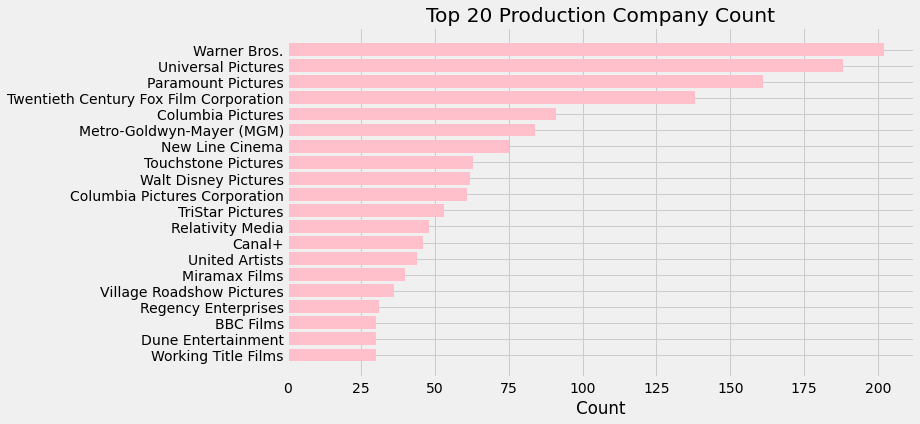

In [34]:
# Counting the frequency of production company 

list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_companies=Counter([i for j in list_of_companies for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_companies)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names, color='pink')
plt.xlabel('Count')
plt.title('Top 20 Production Company Count')
plt.show()

In [35]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 55 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   id                                                         3000 non-null   int64  
 1   belongs_to_collection                                      604 non-null    object 
 2   budget                                                     3000 non-null   int64  
 3   genres                                                     3000 non-null   object 
 4   homepage                                                   946 non-null    object 
 5   imdb_id                                                    3000 non-null   object 
 6   original_language                                          3000 non-null   int32  
 7   original_title                                             3000 non-null   object 
 8   overview

**Cast**

In [36]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(30)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21),
 ('Frank Welker', 20),
 ('Michael Caine', 20),
 ('George Clooney', 20),
 ('Denzel Washington', 20),
 ('Robert Duvall', 20),
 ('Ed Harris', 20),
 ('Dennis Quaid', 20),
 ('Richard Jenkins', 20),
 ('Matt Damon', 20),
 ('Christopher Plummer', 19)]

In [37]:
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(29)]

In [38]:
top_cast_names

['Samuel L. Jackson',
 'Robert De Niro',
 'Morgan Freeman',
 'J.K. Simmons',
 'Bruce Willis',
 'Liam Neeson',
 'Susan Sarandon',
 'Bruce McGill',
 'John Turturro',
 'Forest Whitaker',
 'Willem Dafoe',
 'Bill Murray',
 'Owen Wilson',
 'Nicolas Cage',
 'Sylvester Stallone',
 'Jason Statham',
 'Keith David',
 'John Goodman',
 'Mel Gibson',
 'Sigourney Weaver',
 'Frank Welker',
 'Michael Caine',
 'George Clooney',
 'Denzel Washington',
 'Robert Duvall',
 'Ed Harris',
 'Dennis Quaid',
 'Richard Jenkins',
 'Matt Damon']

In [39]:
train.best_genres = train.genres.apply(lambda y: list(map(lambda x: 1 if (x == "Action" or x == "Adventure" or x == "Family" or x == "Fantasy") else 0, y)))
train["best_genres"] = train.best_genres.apply(lambda x: 1 if (sum(x)>0) else 0)

In [40]:
train["includes_famous_actor"] = train["cast"].apply(lambda x: list(map(lambda y: 1 if (y in top_cast_names) else 0, x)))
#[s for s in train["cast"] if any(xs in s for xs in top_cast_names)]

In [41]:
train["includes_famous_actor"] = train["includes_famous_actor"].apply(lambda x: 1 if (sum(x)>0) else 0)

In [42]:
train["includes_famous_actor"].head(39)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
Name: includes_famous_actor, dtype: int64

In [43]:
 train["includes_famous_actor"]

0       0
1       0
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: includes_famous_actor, Length: 3000, dtype: int64

In [44]:
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)


In [45]:
train

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,[Comedy],NaN,tt2637294,10,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,10,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,0,0,0,0,0
2,3,NaN,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,10,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,0
3,4,NaN,1200000,"[Thriller, Drama]",http://kahaanithefilm.com/,tt1821480,16,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,0,0,0,0,0
4,5,NaN,0,"[Action, Thriller]",NaN,tt1380152,24,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[Comedy, Romance]",NaN,tt0109403,10,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,0,0,0,0,0,0,0,0,0,0
2996,2997,NaN,0,"[Drama, Music]",NaN,tt2364975,35,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,0,0,0,0,0,0,0,0,0,0
2997,2998,NaN,65000000,"[Crime, Action, Mystery, Thriller]",NaN,tt0116908,10,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,0,0,0,0,0,0,0,0,0,0
2998,2999,NaN,42000000,"[Comedy, Romance]",http://www.alongcamepolly.com/,tt0343135,10,Along Came Polly,Reuben Feffer is a guy who's spent his entire ...,15.725542,...,0,0,0,0,0,0,0,0,0,0


**Crew**

In [48]:
directors = train['crew'].apply(lambda x: [i["name"] for i in x if i['job'] == "Director"])
Counter([i for j in directors for i in j]).most_common(15)


[('Ron Howard', 11),
 ('Clint Eastwood', 11),
 ('Steven Spielberg', 10),
 ('Blake Edwards', 9),
 ('Woody Allen', 9),
 ('Wes Craven', 8),
 ('Martin Scorsese', 8),
 ('Paul W.S. Anderson', 8),
 ('Alfred Hitchcock', 8),
 ('Michael Bay', 8),
 ('Francis Ford Coppola', 8),
 ('Brian De Palma', 8),
 ('Steven Soderbergh', 8),
 ('Joel Schumacher', 7),
 ('Peter Hyams', 7)]

In [49]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_directors = [m[0] for m in Counter([i for j in directors for i in j]).most_common(15)]
for g in top_directors:
    train['director_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_directors:
    test['director_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)


In [51]:
train['num_crew']

0       72
1        9
2       64
3        3
4        2
        ..
2995    17
2996    15
2997    10
2998    89
2999    48
Name: num_crew, Length: 3000, dtype: int64

**Taking car of the rest:**

In [52]:
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=True)

original_language              -0.139569
release_year                   -0.071098
production_company_BBC Films   -0.016566
production_company_Canal+      -0.008120
director_Alfred Hitchcock      -0.000128
                                  ...   
popularity                      0.288506
num_crew                        0.341304
budget                          0.485856
revenue                         1.000000
includes_famous_actor                NaN
Name: revenue, Length: 72, dtype: float64

In [62]:
class FeatureAdder(BaseEstimator,TransformerMixin):
    
    def fit(self,df,y=None):
            return self
    
    def transform(self,df, y=None):
            """
            This is done in a cell further up
            df['release_date'] = pd.to_datetime(df['release_date'])
            df['release_year'] = df['release_date'].dt.year
            df['release_month'] = df['release_date'].dt.month
            df.drop(columns=['release_date'], inplace=True)
            df['release_year']=np.where(df['release_year']> 2018, df['release_year']-100, df['release_year'])
            """
            df["tagline"] = df.tagline.isnull() # Only keeping if the movie has a tagline or not
            df["tagline"] = df.tagline.astype("int32")
            
            df["homepage"] = df.homepage.isnull() # Don't care about the address but lets check if movies with a homepage has a higher revenue(or lower).
            df["homepage"] = df.homepage.astype("int32")
            
            df["belongs_to_collection"] = df.belongs_to_collection.isnull()
            df["belongs_to_collection"] = df.belongs_to_collection.astype("int32")
            
            df["title_length"] = df.title.str.len()
            df.drop(columns=["imdb_id"], inplace=True)
            df.drop(columns=["poster_path"], inplace=True)
            df.drop(columns=["status"], inplace=True)
            df.drop(columns=["overview"], inplace=True)
            df.drop(columns=["original_title"], inplace=True)
            df.drop(columns=["spoken_languages"], inplace=True)
            df.drop(columns=["Keywords"], inplace=True)
            df.drop(columns=["production_countries"], inplace=True)
            df.drop(columns=["title"], inplace=True)
            df.drop(columns=['crew'], inplace=True)
            df.drop(columns=['genres'], inplace=True)
            df.drop(columns=['cast'], inplace=True)
            return df

In [56]:
#test


    #return df

#train = date_features(train)
#test = date_features(test)

In [75]:
if("id" in test.columns):
    test = test.drop("id", axis=1)

In [64]:
train = FeatureAdder().fit_transform(train)
test = FeatureAdder().transform(test)

In [65]:
# checking how the train data correlates to label(revenue)

corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)


revenue                  1.000000
budget                   0.485856
num_crew                 0.341304
popularity               0.288506
best_genres              0.235526
                           ...   
original_language       -0.139569
homepage                -0.143133
belongs_to_collection   -0.256553
tagline                 -0.319559
includes_famous_actor         NaN
Name: revenue, Length: 76, dtype: float64

In [66]:
# removing Label(revenue) and id before scaling

train_backup = train 
labels = train["revenue"].copy() 
X=train.drop(['id', 'revenue'], axis=1)


y = np.log1p(train['revenue'])



In [67]:
# pipeline for scaling and imputing

pipeline = Pipeline([
    ("rbt_scaler", RobustScaler()),
    ("imputer", SimpleImputer(strategy="median")),
])

prepared = pipeline.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [68]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.151474	valid_1's rmse: 0.193851
[2000]	training's rmse: 0.129206	valid_1's rmse: 0.192774
Early stopping, best iterat

Weight,Feature
0.3908,budget
0.1984,popularity
0.1047,release_year
0.0882,runtime
0.0513,num_crew
0.0490,release_month
0.0485,title_length
0.0195,num_companies
0.0191,original_language
0.0111,tagline


In [69]:

# Print the best parameters found
gridParams = {
    "max_depth": [4],
    "min_data_in_leaf": [15],
    'learning_rate': [0.01],
    'num_leaves': [40],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501], 
    'reg_alpha' : [1],
    'reg_lambda' : [1.4, 1.5]
    }

grid_search = GridSearchCV(lgb_model, n_jobs=-1, param_grid=gridParams, cv = 3, verbose=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


Random_Search_Params ={
    "max_depth": [4],
    "min_data_in_leaf": [15],
    'learning_rate': [0.01],
    'num_leaves': [40],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501], 
    }

n_HP_points_to_test = 50

random_search = RandomizedSearchCV(
    estimator=lgb_model, param_distributions= Random_Search_Params, 
    n_iter=n_HP_points_to_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

random_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

# Using parameters already set above, replace in the best from the random search

params['learning_rate'] = random_search.best_params_['learning_rate']
params['max_depth'] = random_search.best_params_['max_depth']
params['num_leaves'] = random_search.best_params_['num_leaves']

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   15.9s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   16.8s finished


{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 4, 'min_data_in_leaf': 15, 'num_leaves': 40, 'objective': 'regression', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1.5}
0.23198086897793757
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min finished


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Best score reached: 0.23161666225423416 with params: {'random_state': 501, 'objective': 'regression', 'num_leaves': 40, 'min_data_in_leaf': 15, 'max_depth': 4, 'learning_rate': 0.01, 'boosting_type': 'gbdt

**Random Forrest**

In [70]:


def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# print_score function depending on the evaluation metric: rmse
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)



In [71]:
#rf with hyper parameters
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

**Feature Importance**

In [57]:
fi = rf_feat_importance(m, df_trn)
fi

NameError: name 'rf_feat_importance' is not defined

In [73]:
final_model = grid_search.best_estimator_
test_prepared = pipeline.fit(test)
final_predict = final_model.predict(test)
len(final_predict)


ValueError: could not convert string to float: '7/14/07'

In [59]:
sample_submission = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
# sample_submission['revenue'] = np.expm1(final_prediction + y_pred)/2
sample_submission['revenue'] = np.expm1(final_predict)
sample_submission.to_csv('first.csv', index=False)

NameError: name 'final_predict' is not defined